In [1]:
import numpy as np
import nestle
from scipy.special import ndtri
from time import time               # use for timing functions
import sys
import os
from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib as mpl
import lal
import lalsimulation
rcparams = {}
rcparams['text.usetex'] = True    #font
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 20

# functions for plotting posteriors
import corner
from scipy.stats import gaussian_kde

In [2]:
from __future__ import division
import numpy as np
import lal
import lalsimulation

from scipy.optimize import brentq
from lal import MSUN_SI, C_SI, G_SI

# calculation of frequency
def get_fmin(M,eta,dt1):
    """
    Compute the instantaneous frequency given a time till merger
    """
    M_SI = M*lal.MSUN_SI

    def dtchirp(f):
        """
        The chirp time to 2nd PN order
        """
        v = ((G_SI/C_SI**3)*M_SI*np.pi*f)**(1.0/3.0)
        temp = (v**(-8.0) + ((743.0/252.0) + 11.0*eta/3.0)*v**(-6.0) -
                (32*np.pi/5.0)*v**(-5.0) + ((3058673.0/508032.0) + 5429*eta/504.0 +
                (617.0/72.0)*eta**2)*v**(-4.0))
        return (5.0/(256.0*eta))*(G_SI/C_SI**3)*M_SI*temp - dt1

    # solve for the frequency between limits
    fmin = brentq(dtchirp, 1e-4, 2000.0, xtol=1e-6)
    print('signal enters segment at {} Hz'.format(fmin))

    return fmin

m1 = 36
m2 = 29
M = m1 + m2
eta = m1*m2/M**2
dt1 = 86400*30*5
print(eta)

fmin = get_fmin(M,eta,dt1)
print(fmin)

0.24710059171597634
signal enters segment at 0.040465078092627234 Hz
0.040465078092627234


In [3]:
# set the true values of the model parameters for creating the data
# the third observation window (one month obsevation time of LISA, six months before merger)
T_obs1 = 2592000 # time of the observation of LISA
fs1 = 0.08 # sampling frequency 

T_obs2 = 4 # time of the observation of aLIGO
fs2 = 2048 # sampling frequency
f_low1=0.0377 # the lowest frequency (Hz)
f_low2=10
m1 = 36  # mass (solar mass)
m2 = 29
dist=100 # distance (Mpc)
phi=1.3  # phase (radians)
iota=0.4  #inclination angle (radians)

asd1=1e-20  # amplitude spectral density 
sigma1=asd1*np.sqrt(fs1*T_obs1/2.0)
asd2=5e-24
sigma2=asd2*np.sqrt(fs2*T_obs2/2.0)
# set the natural logarithm of 2pi, so that it doesn't have to be recalculated
LN2PI = np.log(2.*np.pi)
LNSIGMA1 = np.log(sigma1) # natural log of the data noise standard deviation
LNSIGMA2 = np.log(sigma2)
# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

In [4]:
#def plotposts(samples, truths=[m1, m2, dist, iota, phi]):
def plotposts(samples, outfile, **kwargs):   #graphic display
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m1, m2, dist, iota, phi]

    fig = corner.corner(samples, labels=[r'$m1$', r'$m2$',r'$dist$',r'$iota$',r'$phi$'],quantiles=(0.16,0.84), show_titles=True,hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    #for axidx, samps in zip([0, 3], samples.T):
        #kde = gaussian_kde(samps)
        #xvals = fig.axes[axidx].get_xlim()
        #xvals = np.linspace(xvals[0], xvals[1], 100)
        #fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
    
    pl.savefig(outfile)

In [5]:
def gen_bbh(T_obs, fs, f_low, m1, m2, dist, iota, phi):
    """
    generates a BBH timedomain signal
    """
    N = T_obs * fs      # the total number of samples
    dt = 1 / fs             # the sampling time (sec)
    #f_low = 0.9            # lowest frequency of waveform (Hz)
    f_high=fs/2.0           # highest frequency of waveform (Hz)
    amplitude_order = 0
    phase_order = 8
    approximant = lalsimulation.IMRPhenomD
    #dist = 1e6*lal.PC_SI  # put it as 1 MPc
    
    
    # make waveform
    hp, hc = lalsimulation.SimInspiralChooseFDWaveform(
                    m1 * lal.MSUN_SI, m2 * lal.MSUN_SI,
                    0, 0, 0, 0, 0, 0,
                    dist*1e6*lal.PC_SI,
                    iota,phi,0,   
                    0, 0,
                    1.0/ T_obs,
                    f_low,f_high,f_low,
                    lal.CreateDict(),
                    approximant)

     
    return hp.data.data

In [6]:
def prior_transform(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """
    m1prime, m2prime, distprime, iotaprime, phiprime = theta # unpack the parameters (in their unit hypercube form)
  
    m1min= 20 # lower bound on uniform prior on m1
    m1max=50 # upper bound on uniform prior on m1
    
    m2min=20  # lower bound on uniform prior on m2
    m2max=50  # upper bound on uniform prior on m2

    distmin = 50# lower bound on uniform prior on dist
    distmax =2000# upper bound on uniform prior on dist
    
    iotamin=0  # lower bound on uniform prior on iota
    iotamax=np.pi # upper bound on uniform prior on iota
    
    phimin=0
    phimax=2*np.pi
    
 # keep m1 always larger than m2
    m1 = m1prime*(m1max-m1min) + m1min
    m2 = m2prime*(m2max-m2min) + m2min
        
  
    m1temp = m1prime*(m1max-m1min) + m1min
    m2temp = m2prime*(m2max-m2min) + m2min
    #phitemp = phiprime*(phimax-phimin) + phimin
    m1 = m1temp
    m2 = m2temp
    #phi = phitemp
    if m2>m1:
        m1=m2temp
        m2=m1temp
        #phi = np.mod(phitemp + np.pi, 2.0*np.pi)
        #phi = np.mod(phitemp + np.pi, np.pi)

 
    dist = distprime*(distmax-distmin) + distmin
    iota = iotaprime*(iotamax-iotamin) + iotamin
    phi = phiprime*(phimax-phimin) + phimin


    return (m1, m2, dist, iota, phi)

In [7]:
def loglikelihood_nestle1(theta):
    """
    The log-likelihood function.
    """

    m1, m2, dist, iota, phi = theta # unpack the parameters
    # keep m1 always larger than m2
    #if m2>m1:
        #return -np.inf

    # normalisation
    norm1 = -0.5*M1*LN2PI - M1*LNSIGMA1
    
    signal1=gen_bbh(T_obs1, fs1,f_low1, m1, m2, dist, iota, phi)
    df1=1.0/T_obs1
    sidx1=int(f_low1/df1)

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    # two parts, real, imag
    chisq1 = np.sum(((data1[sidx1:].real-signal1[sidx1:].real)/sigma1)**2)
    chisq1 += np.sum(((data1[sidx1:].imag-signal1[sidx1:].imag)/sigma1)**2)
    
    return norm1 - 0.5*chisq1

Nestle version: 0.2.0
131073


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


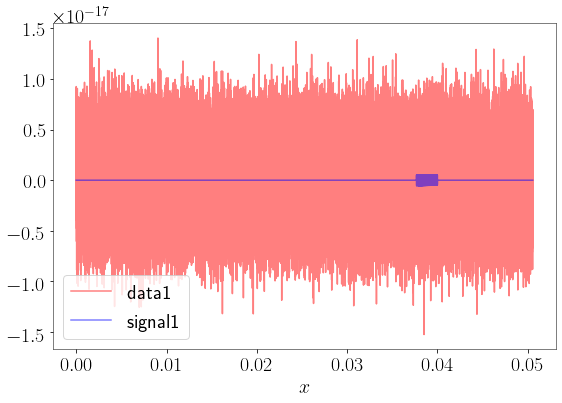

In [8]:
print('Nestle version: {}'.format(nestle.__version__))

# seed our random number generator, so we have reproducible data
np.random.seed(np.random.seed(42)) #sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
signal1 = gen_bbh(T_obs1, fs1,f_low1, m1, m2, dist, iota, phi) 
M1=signal1.shape[0]
data1=signal1+ sigma1*(np.random.randn(M1)+np.random.randn(M1)*1j)
print(M1)

# plot the data
mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = pl.subplots(figsize=(9,6))
f1=np.arange(M1)/T_obs1
#ax.semilogx(f1,data1.real, 'r', alpha=0.5, label='data1')
ax.plot(f1,data1.real, 'r', alpha=0.5, label='data1')
ax.plot(f1,signal1.real, 'b', alpha=0.5, label='signal1')
#ax.plot(x, gen_bbh(T_obs, fs, m1, m2, dist, iota, phi), 'r-', lw=2, label='model')
ax.legend()
#ax.set_xlim([0.12, 0.14])
ax.set_xlabel(r'$x$')
pl.savefig('./data9m.png') 


it= 22083 logz=5125664.613273Time taken to run 'Nestle' is 186950.3218278885 seconds
log(Z) = 5125664.701834783 ± 0.1316911534322376
niter: 22084
ncall: 73065824
nsamples: 23108
logz: 5125664.702 +/-  0.132
h: 17.759
Number of posterior samples is 3241
Effective samples per second: 0


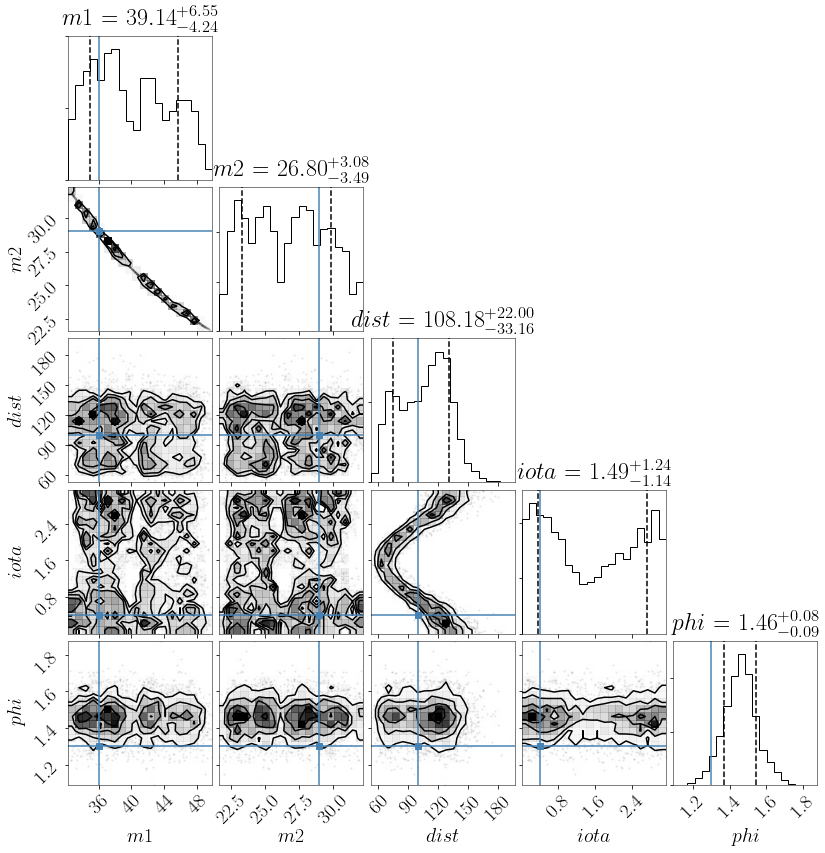

In [9]:
nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 5        # five parameters
tol = 0.1        # the stopping criterion

t0 = time()
res1 = nestle.sample(loglikelihood_nestle1, prior_transform, ndims, method=method, npoints=nlive, dlogz=tol,callback=nestle.print_progress)
t1 = time()
# cost of time
timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

logZnestle = res1.logz                         # value of logZ
infogainnestle = res1.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZnestle, logZerrnestle))

print(res1.summary())

# re-scale weights to have a maximum of one
nweights = res1.weights/np.max(res1.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res1.samples[keepidx,:]

# lets store some results for showing together later
resdict = {}

resdict['m1nestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m1 samples
resdict['m1nestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m1 samples
resdict['m2nestle_mu'] = np.mean(samples_nestle[:,1])      # mean of m2 samples
resdict['m2nestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of m2 samples

resdict['distnestle_mu'] = np.mean(samples_nestle[:,2])      # mean of dist samples
resdict['distnestle_sig'] = np.std(samples_nestle[:,2])      # standard deviation of dist samples

resdict['iotanestle_mu'] = np.mean(samples_nestle[:,3])      # mean of iota samples
resdict['iotanestle_sig'] = np.std(samples_nestle[:,3])      # standard deviation of iota samples

resdict['phinestle_mu'] = np.mean(samples_nestle[:,4])      # mean of phi samples
resdict['phinestle_sig'] = np.std(samples_nestle[:,4])      # standard deviation of phi samples

#resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters


resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

plotposts(samples_nestle,'./corner_9LISA.png')

resdict['essnestle'] = int(len(samples_nestle)/ timenestle)
print("Effective samples per second: {}".format(resdict['essnestle']))

In [10]:
def loglikelihood_nestle2(theta):
    """
    The log-likelihood function.
    """

    m1, m2, dist, iota, phi = theta # unpack the parameters
    #if m2>m1:
        #return -np.inf

    # normalisation
    norm2 = -0.5*M2*LN2PI - M2*LNSIGMA2
    
    signal2=gen_bbh(T_obs2, fs2,f_low2, m1, m2, dist, iota, phi)
    df2=1.0/T_obs2
    sidx2=int(f_low2/df2)

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq2 = np.sum(((data2[sidx2:].real-signal2[sidx2:].real)/sigma2)**2)
    chisq2 += np.sum(((data2[sidx2:].imag-signal2[sidx2:].imag)/sigma2)**2)
    
    return norm2 - 0.5*chisq2

Nestle version: 0.2.0


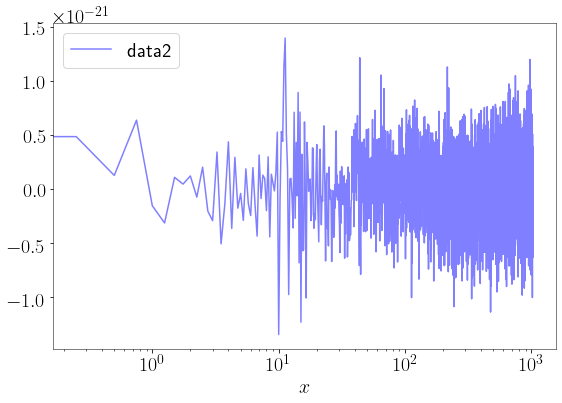

In [11]:
print('Nestle version: {}'.format(nestle.__version__))

# seed our random number generator, so we have reproducible data
np.random.seed(np.random.seed(42)) #sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
signal2 = gen_bbh(T_obs2, fs2, f_low2, m1, m2, dist, iota, phi) 
M2=signal2.shape[0]
data2=signal2+ sigma2*(np.random.randn(M2)+np.random.randn(M2)*1j)

# plot the data
mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = pl.subplots(figsize=(9,6))

f2=np.arange(M2)/T_obs2
ax.semilogx(f2,data2.real, 'b', alpha=0.5, label='data2')
#ax.plot(x, gen_bbh(T_obs, fs, m1, m2, dist, iota, phi), 'r-', lw=2, label='model')
ax.legend()
#ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$')
pl.savefig('./data5.png') 
#exit(0)

it= 17617 logz=195000.213100Time taken to run 'Nestle' is 165.50225496292114 seconds
log(Z) = 195000.29649013514 ± 0.1136428174991115
niter: 17618
ncall: 72483
nsamples: 18642
logz: 195000.296 +/-  0.114
h: 13.225
Number of posterior samples is 3369
Effective samples per second: 20


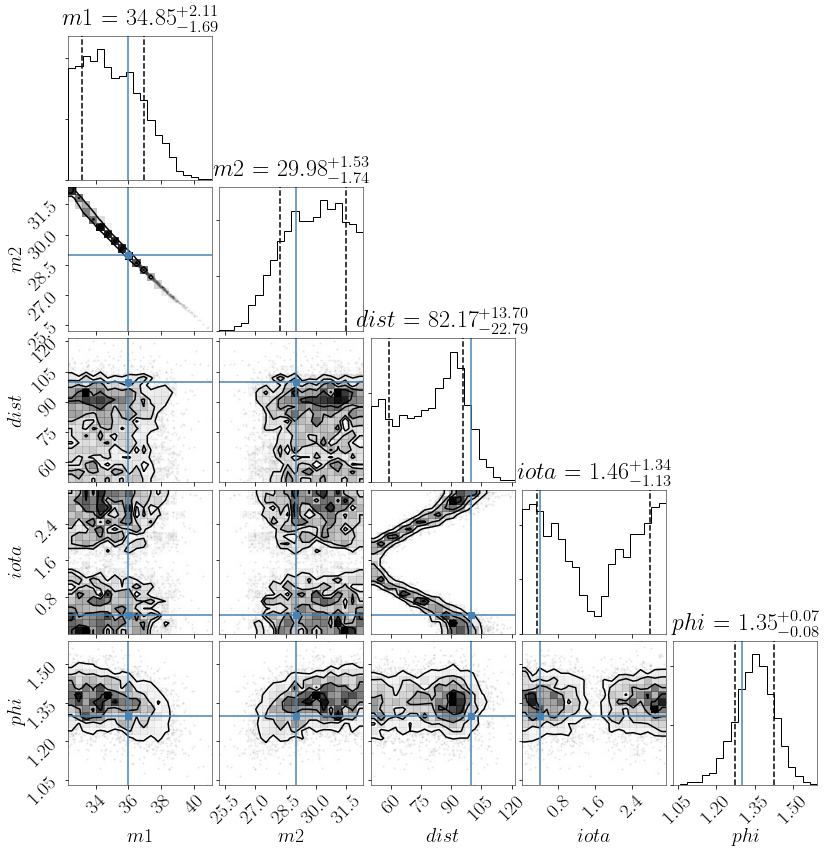

In [12]:
nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 5        # two parameters
tol = 0.1        # the stopping criterion

t0 = time()
res2 = nestle.sample(loglikelihood_nestle2, prior_transform, ndims, method=method, npoints=nlive, dlogz=tol,callback=nestle.print_progress)
t1 = time()

timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

logZnestle = res2.logz                         # value of logZ
infogainnestle = res2.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZnestle, logZerrnestle))

print(res2.summary())

# re-scale weights to have a maximum of one
nweights = res2.weights/np.max(res2.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res2.samples[keepidx,:]

# lets store some results for showing together later
resdict = {}

resdict['m1nestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m1 samples
resdict['m1nestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m1 samples
resdict['m2nestle_mu'] = np.mean(samples_nestle[:,1])      # mean of m2 samples
resdict['m2nestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of m2 samples

resdict['distnestle_mu'] = np.mean(samples_nestle[:,2])      # mean of dist samples
resdict['distnestle_sig'] = np.std(samples_nestle[:,2])      # standard deviation of dist samples

resdict['iotanestle_mu'] = np.mean(samples_nestle[:,3])      # mean of iota samples
resdict['iotanestle_sig'] = np.std(samples_nestle[:,3])      # standard deviation of iota samples

resdict['phinestle_mu'] = np.mean(samples_nestle[:,4])      # mean of phi samples
resdict['phinestle_sig'] = np.std(samples_nestle[:,4])      # standard deviation of phi samples

#resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters


resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

plotposts(samples_nestle,'./corner_2LIGO.png')

resdict['essnestle'] = int(len(samples_nestle)/ timenestle)
print("Effective samples per second: {}".format(resdict['essnestle']))

In [13]:
def loglikelihood_nestle3(theta):
    """
    The log-likelihood function.
    """

    m1, m2, dist, iota, phi = theta # unpack the parameters

    # normalisation
    norm1 = -0.5*M1*LN2PI - M1*LNSIGMA1
    
    signal1=gen_bbh(T_obs1, fs1,f_low1, m1, m2, dist, iota, phi)

    df1=1.0/T_obs1
    sidx1=int(f_low1/df1)

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq1 = np.sum(((data1[sidx1:].real-signal1[sidx1:].real)/sigma1)**2)
    chisq1 += np.sum(((data1[sidx1:].imag-signal1[sidx1:].imag)/sigma1)**2)
    
    # normalisation
    norm2 = -0.5*M2*LN2PI - M2*LNSIGMA2
    
    signal2=gen_bbh(T_obs2, fs2,f_low2, m1, m2, dist, iota, phi)
    df2=1.0/T_obs2
    sidx2=int(f_low2/df2)
    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq2 = np.sum(((data2[sidx2:].real-signal2[sidx2:].real)/sigma2)**2)
    chisq2 += np.sum(((data2[sidx2:].imag-signal2[sidx2:].imag)/sigma2)**2)
    
    return norm1 - 0.5*chisq1+norm2 - 0.5*chisq2

Nestle version: 0.2.0


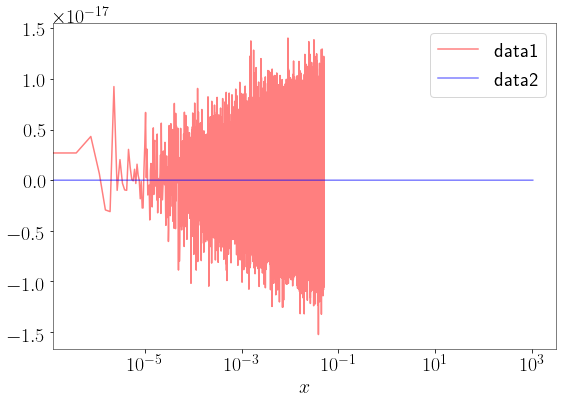

In [14]:
print('Nestle version: {}'.format(nestle.__version__))


# seed our random number generator, so we have reproducible data
np.random.seed(np.random.seed(42)) #sum([ord(v) for v in 'samplers']))

# plot the data
mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = pl.subplots(figsize=(9,6))

ax.semilogx(f1,data1.real, 'r', alpha=0.5, label='data1')
ax.semilogx(f2,data2.real, 'b', alpha=0.5, label='data2')
#ax.plot(x, gen_bbh(T_obs, fs, m1, m2, dist, iota, phi), 'r-', lw=2, label='model')
ax.legend()
#ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$')
pl.savefig('./data6.png') 
#exit(0)

it= 25992 logz=5320672.203392Time taken to run 'Nestle' is 17166.38713312149 seconds
log(Z) = 5320672.284286072 ± 0.14398646393660122
niter: 25993
ncall: 5457362
nsamples: 27017
logz: 5320672.284 +/-  0.144
h: 21.230
Number of posterior samples is 3496
Effective samples per second: 0


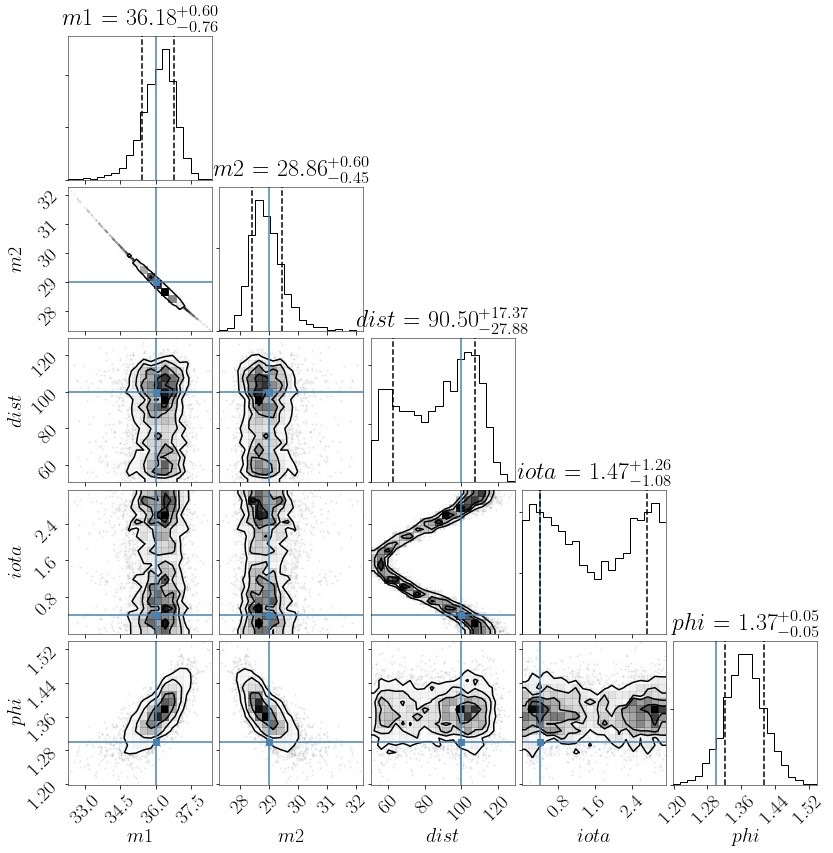

In [15]:
nlive = 1024     # number of live points
method = 'multi' # use MutliNest algorithm
ndims = 5        # two parameters
tol = 0.1        # the stopping criterion

t0 = time()
res3 = nestle.sample(loglikelihood_nestle3, prior_transform, ndims, method=method, npoints=nlive, dlogz=tol,callback=nestle.print_progress)
t1 = time()

timenestle = (t1-t0)

print("Time taken to run 'Nestle' is {} seconds".format(timenestle))

logZnestle = res3.logz                         # value of logZ
infogainnestle = res3.h                        # value of the information gain in nats
logZerrnestle = np.sqrt(infogainnestle/nlive) # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZnestle, logZerrnestle))

print(res3.summary())

# re-scale weights to have a maximum of one
nweights = res3.weights/np.max(res3.weights)

# get the probability of keeping a sample from the weights
keepidx = np.where(np.random.rand(len(nweights)) < nweights)[0]

# get the posterior samples
samples_nestle = res3.samples[keepidx,:]

# lets store some results for showing together later
resdict = {}

resdict['m1nestle_mu'] = np.mean(samples_nestle[:,0])      # mean of m1 samples
resdict['m1nestle_sig'] = np.std(samples_nestle[:,0])      # standard deviation of m1 samples
resdict['m2nestle_mu'] = np.mean(samples_nestle[:,1])      # mean of m2 samples
resdict['m2nestle_sig'] = np.std(samples_nestle[:,1])      # standard deviation of m2 samples

resdict['distnestle_mu'] = np.mean(samples_nestle[:,2])      # mean of dist samples
resdict['distnestle_sig'] = np.std(samples_nestle[:,2])      # standard deviation of dist samples

resdict['iotanestle_mu'] = np.mean(samples_nestle[:,3])      # mean of iota samples
resdict['iotanestle_sig'] = np.std(samples_nestle[:,3])      # standard deviation of iota samples

resdict['phinestle_mu'] = np.mean(samples_nestle[:,4])      # mean of phi samples
resdict['phinestle_sig'] = np.std(samples_nestle[:,4])      # standard deviation of phi samples

#resdict['ccnestle'] = np.corrcoef(samples_nestle.T)[0,1]  # correlation coefficient between parameters


resdict['nestle_npos'] = len(samples_nestle)              # number of posterior samples
resdict['nestle_time'] = timenestle                       # run time
resdict['nestle_logZ'] = logZnestle                       # log marginalised likelihood
resdict['nestle_logZerr'] = logZerrnestle                 # uncertainty on log(Z)

print('Number of posterior samples is {}'.format(len(samples_nestle)))

plotposts(samples_nestle,'./corner_2both.png')

resdict['essnestle'] = int(len(samples_nestle)/ timenestle)
print("Effective samples per second: {}".format(resdict['essnestle']))